# Data Description


* **client_id** - client's id number 


* **education** - level of education


* **sex** - client's sex


* **age** - client's age


* **car** - car presence 


* **car_type**	- foreign car or not


* **decline_app_cnt** - number of previous credit refusals


* **good_work** -	"good" job presence


* **bki_request_cnt** - number of loan requests to Credit Bureau


* **home_address** - category of home address


* **work_address** - category of work address


* **income** - client's income


* **foreign_passport** - foreign passport presence


* **default** - default presence (i.e. failure to fulfil an obligation/to repay a loan)


* **app_date** - application date


* **first_time** - how long the bank has info about this client


* **sna** - relation to bank's clients


* **region_rating** - client's region rating

# Import of modules

In [70]:
import pandas as pd
import numpy as np
import scipy
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.feature_selection import f_classif, mutual_info_classif, chi2
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier


from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import auc, roc_auc_score, roc_curve, balanced_accuracy_score

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go
init_notebook_mode(connected=True)
%matplotlib inline

# Setting default graph parameters
sns.set(style='whitegrid')
from pylab import rcParams
rcParams['figure.figsize'] = 13, 7
rcParams['xtick.labelsize'] = 13
rcParams['ytick.labelsize'] = 13
rcParams['axes.labelsize'] = 15


# import warnings
# warnings.simplefilter('ignore')

Some functions for convenience:

In [71]:
def countplot(data, column):
    sns.countplot(data[column], palette='magma')
    plt.title(f'Bar plot for "{column}"', size=18)
    plt.ylabel('Counts')
    plt.xlabel('Categories')
    plt.show()
    

In [72]:
def distplot(data, column):
    sns.distplot(data[column], color='m')
    plt.title(f'Distribution for "{column}"', size=18)
    plt.ylabel('Density')
    plt.xlabel('Values')
    plt.show()

[More **rcParams**](https://matplotlib.org/3.3.2/tutorials/introductory/customizing.html)


# Data overview and preprocessing

In [73]:
train = pd.read_csv('../input/sf-dst-scoring/train.csv')
train

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,04MAR2014,GRD,F,45,N,N,0,0,-1.792064,3,50,1,2,17000,4,4,N,0
73795,76821,24MAR2014,SCH,M,41,Y,Y,0,0,-2.058029,1,50,2,2,70000,1,4,N,0
73796,103695,22APR2014,SCH,M,31,N,N,0,0,-1.512635,4,80,2,3,45000,2,2,N,0
73797,861,04JAN2014,SCH,F,29,N,N,0,1,-1.479334,3,50,1,3,13000,2,3,N,1


In [74]:
test = pd.read_csv('../input/sf-dst-scoring/test.csv')
test

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36344,83775,31MAR2014,SCH,F,37,N,N,1,0,-1.744976,3,50,2,3,15000,4,1,N
36345,106254,25APR2014,GRD,F,64,Y,Y,0,0,-2.293781,3,60,1,2,200000,1,4,N
36346,81852,30MAR2014,GRD,M,31,N,N,2,0,-0.940752,1,50,1,2,60000,4,2,N
36347,1971,07JAN2014,UGR,F,27,N,N,1,0,-1.242392,2,80,2,3,30000,1,1,N


Adding a mark for train and test samples and concatenating them:

In [75]:
# 1 means train sample, 0 - test sample (for convenience)
train['sample'] = 1
test['sample'] = 0
test['default'] = 0  # Filling with 0, since no values here
data = pd.concat([train, test], axis=0, ignore_index=True)

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [77]:
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,1


Checking for nan-values' proportions and amounts and presence of duplicated rows:

In [78]:
print(f'Proportions:\n{data.isna().mean()}\n\nAmounts:\n{data.isna().sum()}')
print(f'\nNumber of duplicates: {data.duplicated().sum()}')

Proportions:
client_id           0.00000
app_date            0.00000
education           0.00434
sex                 0.00000
age                 0.00000
car                 0.00000
car_type            0.00000
decline_app_cnt     0.00000
good_work           0.00000
score_bki           0.00000
bki_request_cnt     0.00000
region_rating       0.00000
home_address        0.00000
work_address        0.00000
income              0.00000
sna                 0.00000
first_time          0.00000
foreign_passport    0.00000
default             0.00000
sample              0.00000
dtype: float64

Amounts:
client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time        



The "education" column has approximately 0,4% missing values.

Proportions fro "default" column:

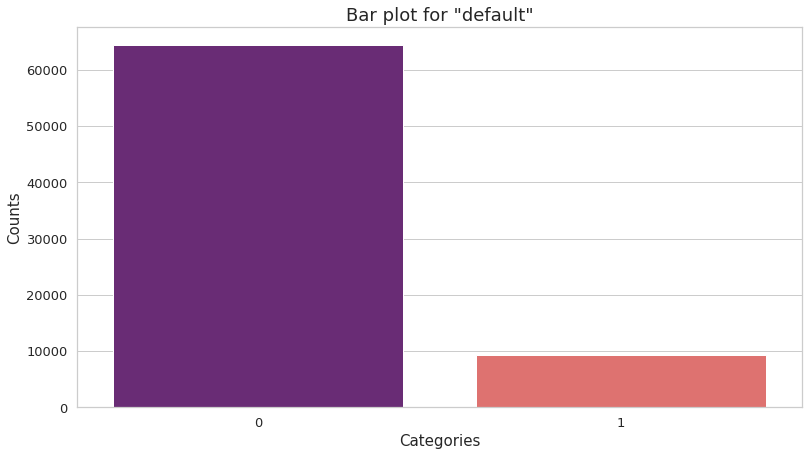

In [79]:
countplot(data[data['sample'] == 1], 'default');

Apparently, there is a class disbalance since the number of non-default clients is about six times higher than the number of default clients.

Since "education" is the only column with missing values, here is its bar plot:

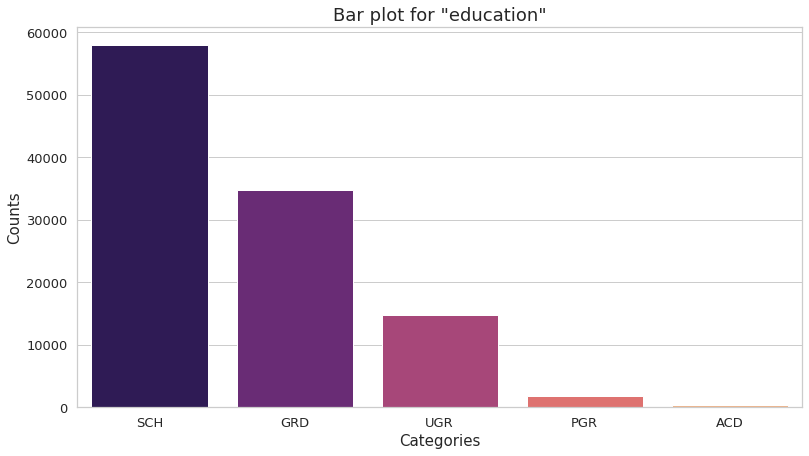

In [80]:
countplot(data, 'education');

Since "education" column contains missing values, it makes sense to impute them using kNN method:

In [81]:
# Dropping an unnecessary column
data.drop(['client_id'], axis=1, inplace=True)

In [82]:
# Got dataframes with and without missing values
X = data[~data.education.isna()].drop(['app_date', 'default', 'sample'], axis=1)
X_nan = data[data.education.isna()].drop(['app_date', 'default', 'sample'], axis=1)

# Encoding education classes
encoder = LabelEncoder()
encoder.fit(X.education)
education_labeled = encoder.transform(X.education)
X.loc[:, ['education']] = education_labeled

# Getting matrices from dataframes
X = pd.get_dummies(X)
X_nan = pd.get_dummies(X_nan.fillna(value=0))

# Scaling values
scaler = StandardScaler()
scaler.fit(X.iloc[:, 1:])
X_train = scaler.transform(X.iloc[:, 1:])
y_train = X.iloc[:, 0].values

X_test = scaler.transform(X_nan.iloc[:, 1:])
y_test = X_nan.iloc[:, 0].values

In [83]:
# Building KNN model for education prediction
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_pred = encoder.inverse_transform(y_pred)

In [84]:
# Substituting missing values with predictions
nan_indices = data[data.education.isna()].index
data.iloc[nan_indices, 1] = y_pred
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   app_date          110148 non-null  object 
 1   education         110148 non-null  object 
 2   sex               110148 non-null  object 
 3   age               110148 non-null  int64  
 4   car               110148 non-null  object 
 5   car_type          110148 non-null  object 
 6   decline_app_cnt   110148 non-null  int64  
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  int64  
 10  region_rating     110148 non-null  int64  
 11  home_address      110148 non-null  int64  
 12  work_address      110148 non-null  int64  
 13  income            110148 non-null  int64  
 14  sna               110148 non-null  int64  
 15  first_time        110148 non-null  int64  
 16  foreign_passport  11

In [85]:
data.head()

,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1
1,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,1
2,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,1
3,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,1
4,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,1


In [86]:
# Converting the column with categorical dates into datetime format
data['app_date'] = pd.to_datetime(data['app_date'])

In [87]:
# Dividing features into 3 lists for convenience
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki', 'region_rating']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'home_address', 'work_address', 'first_time', 'sna']
target = 'default'

Actually, it is more convenient to use **LabelEncoder()** class from **sklearn**. 
```python
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder\
                             .fit_transform(data['sex']))
print(dict(enumerate(label_encoder.classes_)))
# -> {0: 'F', 1: 'M'}
```



This way it is possible to encode all the binary features using *for* loops:


In [88]:
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    # Checking if the encoding was performed correctly
    print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}
{0: 'N', 1: 'Y'}
{0: 'N', 1: 'Y'}
{0: 0, 1: 1}
{0: 'N', 1: 'Y'}


In [89]:
data.head()

,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,2014-02-01,SCH,1,62,1,1,0,0,-2.008753,1,50,1,2,18000,4,1,0,0,1
1,2014-03-12,SCH,0,59,0,0,0,0,-1.532276,3,50,2,3,19000,4,1,0,0,1
2,2014-02-01,SCH,1,25,1,0,2,0,-1.408142,1,80,1,2,30000,1,4,1,0,1
3,2014-01-23,SCH,0,53,0,0,0,0,-2.057471,2,50,2,3,10000,1,3,0,0,1
4,2014-04-18,GRD,1,48,0,0,0,1,-1.244723,1,60,2,3,30000,1,4,1,0,1


## Categorical features


**Sex column:**

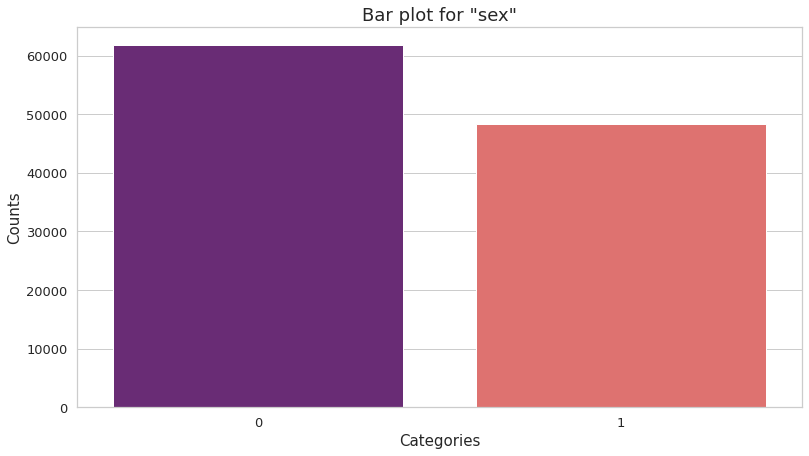

In [90]:
countplot(data, 'sex')

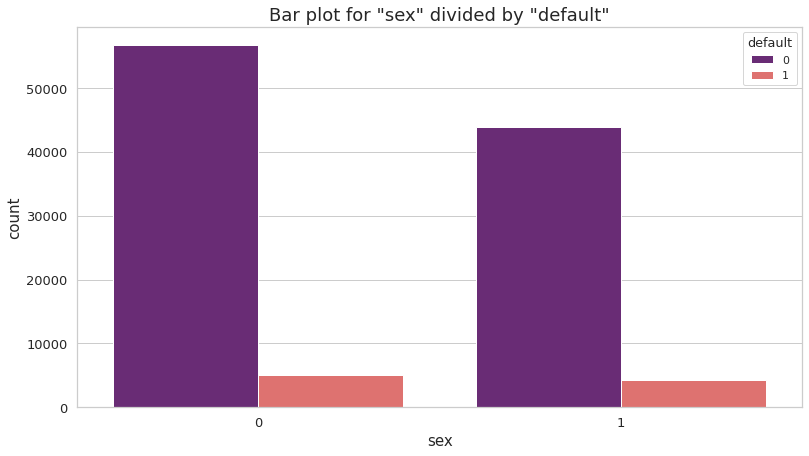

In [91]:
sns.countplot(data.sex, hue=data.default, palette='magma')
plt.title('Bar plot for "sex" divided by "default"', size=18);

* There are more men in the dataset

* Generally, the amount of defaulted people among men and women does not differ that much - the proportion looks similar


**Car and car type:**

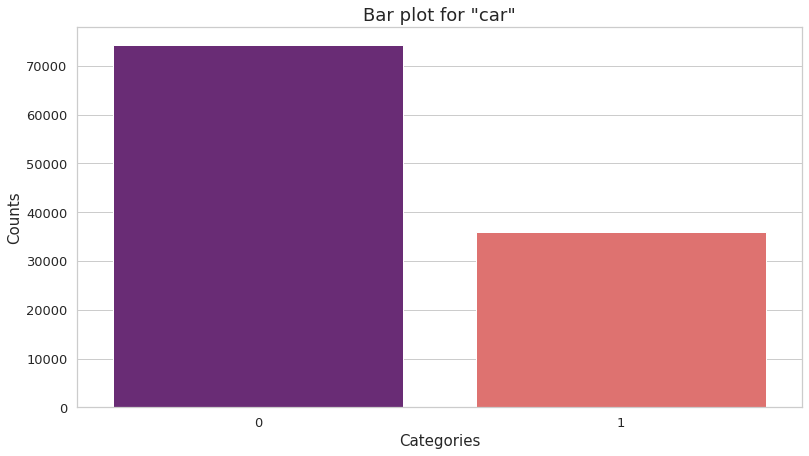

In [92]:
countplot(data, 'car')

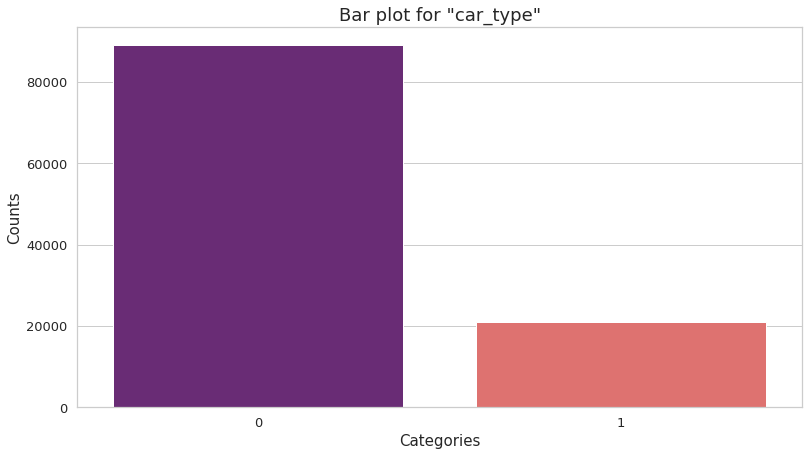

In [93]:
countplot(data, 'car_type')

Let's look, what cars prefer car owners:

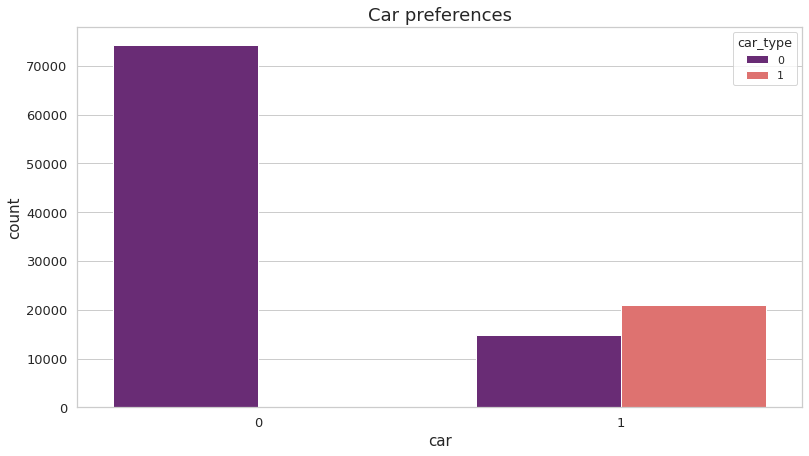

In [94]:
sns.countplot(data.car, hue=data.car_type, palette='magma')
plt.title('Car preferences', size=18);

* There are more people using foreign cars then domestic cars

**Good work:**

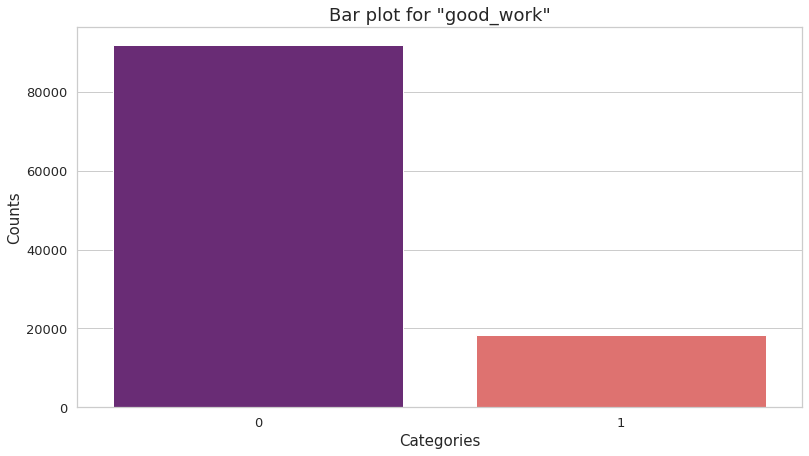

In [95]:
countplot(data, 'good_work')

* The majority of people are considered to have "bad" job (probably in financial terms)

**Home address:**

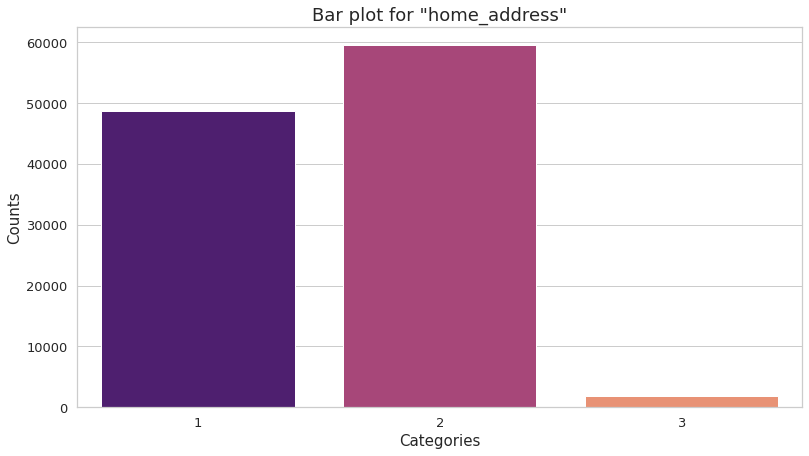

In [96]:
countplot(data, 'home_address')

* There are much fewer observations with home address "3" 

**Work address:**

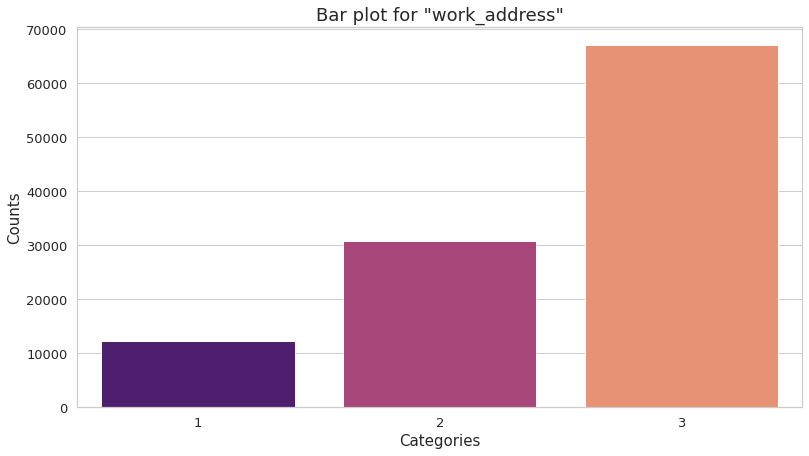

In [97]:
countplot(data, 'work_address')

* Most people work on work address "3"


Let's see how work address depends on home address:

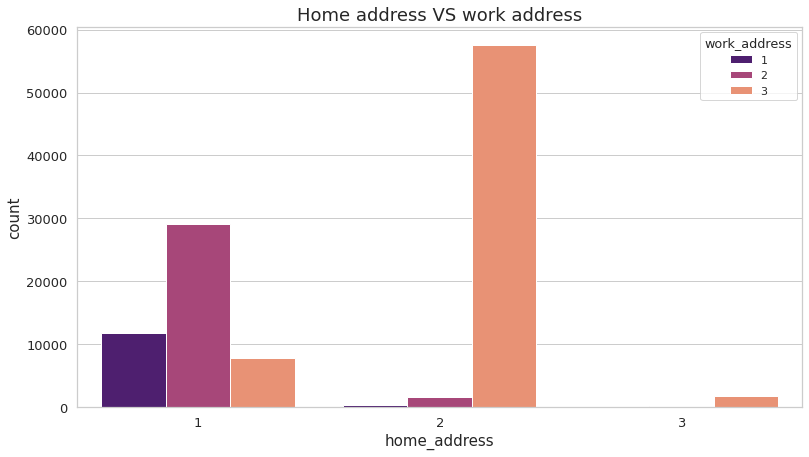

In [98]:
sns.countplot(data.home_address, hue=data.work_address, palette='magma')
plt.title('Home address VS work address', size=18);

* People from "1" home address mostly work on "2" work address

* A huge number of people living on "2" home address work on "3"" work address

* People from "3" home address work only on "3" work_address


**SNA column:**

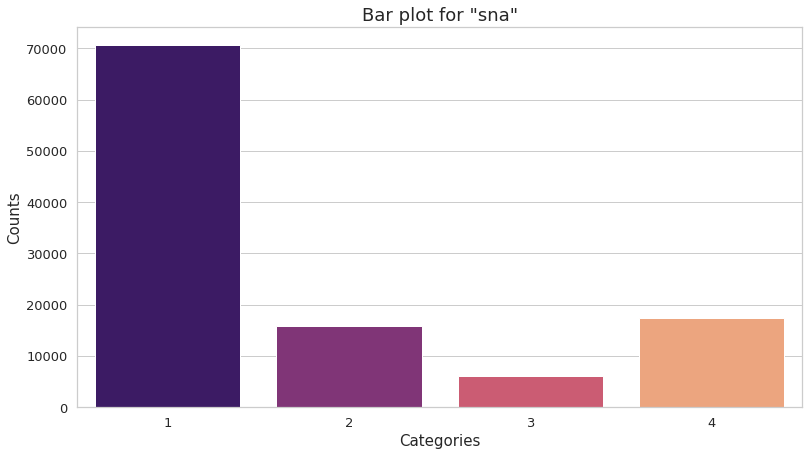

In [99]:
countplot(data, 'sna')

* Most people have no relatives or friends who are clients of this bank

**First time**:

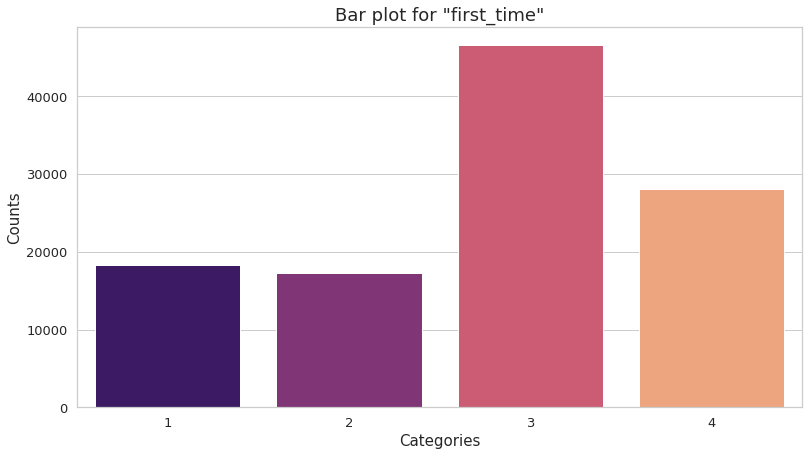

In [100]:
countplot(data, 'first_time')

* Most clients are in bank's databases for a long time

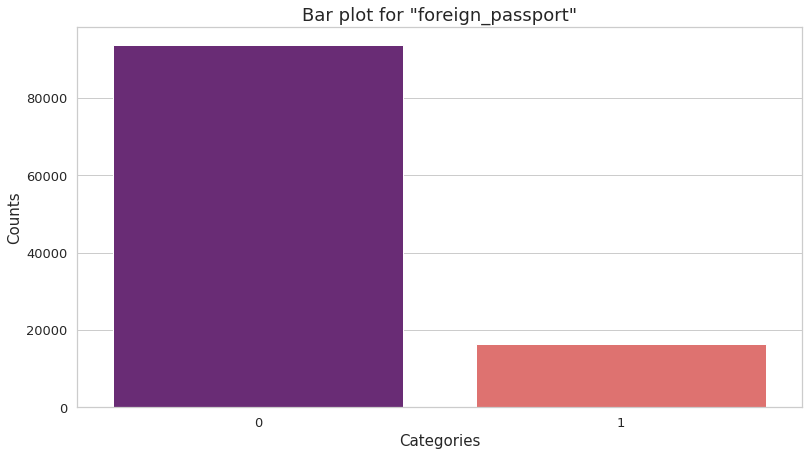

In [101]:
countplot(data, 'foreign_passport')

* Most people have no foreign passport 

## Numeric features

Distributions for numeric features:

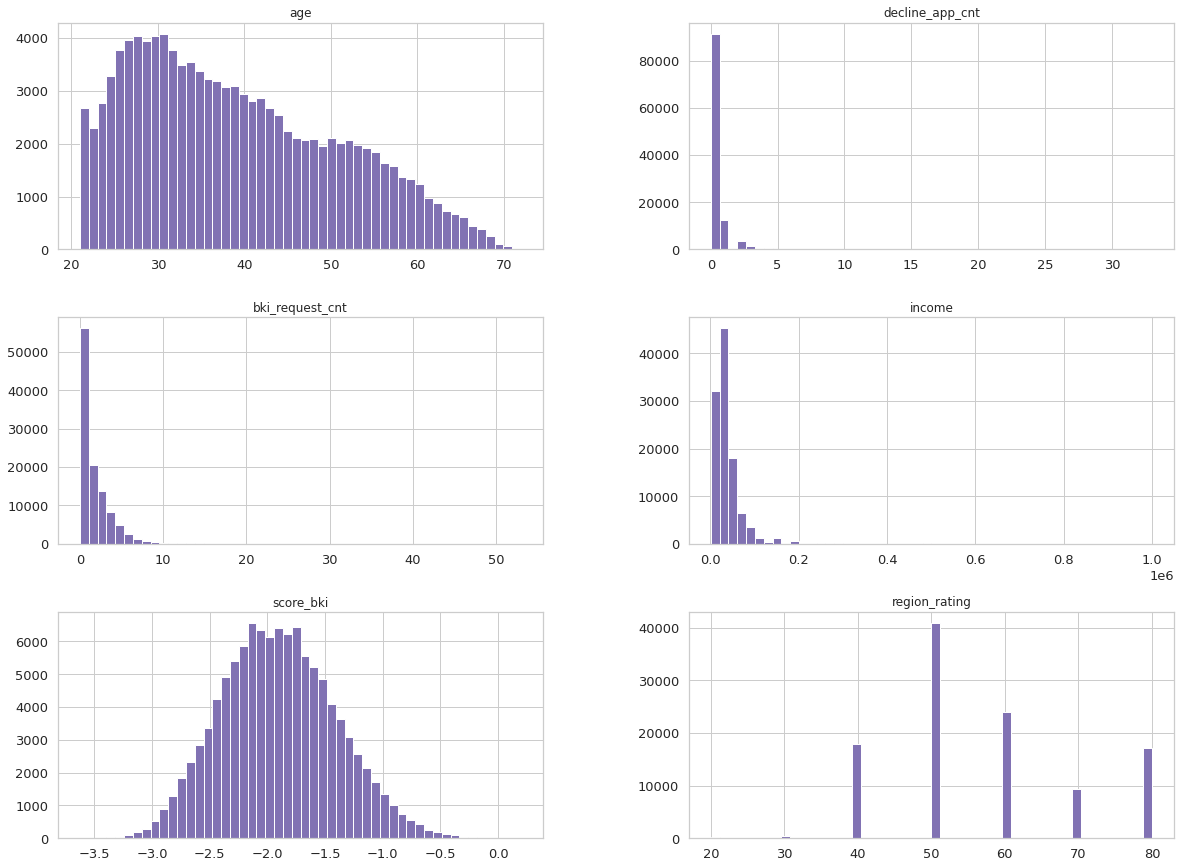

In [102]:
data[num_cols].hist(bins=50, figsize=(20, 15), color='m');

There is a kind of tail on the right side of each distribution which does not allow to have a normal one.

We can use logarithms of these features to get normal distirubtions:

In [103]:
log_df = data[num_cols].copy(deep=True)
for col in log_df.columns:
    log_df[col] = log_df[col].apply(lambda x: np.log(x + 1))

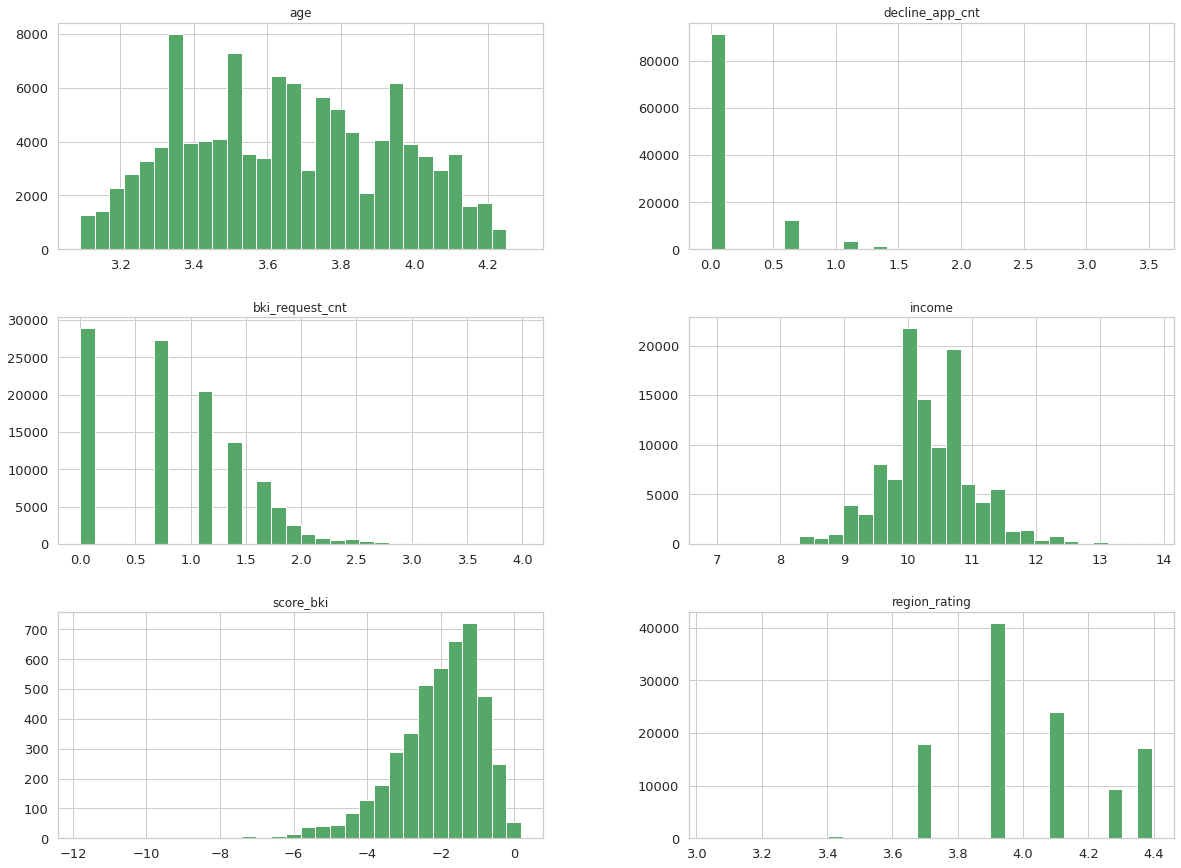

In [104]:
log_df.hist(bins=30, figsize=(20, 15), color='g');

Some of the features have a distribution which is more similar to the normal one but others have lost their normality.

In [105]:
log_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   age              110148 non-null  float64
 1   decline_app_cnt  110148 non-null  float64
 2   bki_request_cnt  110148 non-null  float64
 3   income           110148 non-null  float64
 4   score_bki        4450 non-null    float64
 5   region_rating    110148 non-null  float64
dtypes: float64(6)
memory usage: 5.0 MB


Moreover, a lot of observations have been lost after logarithmic transformation.

Let's transform some features to logarithmic form as above to decrease the skewness:

In [106]:
data['income'] = [np.log(x) for x in data['income']]
data['age'] = [np.log(x + 1) for x in data['age']]
data['decline_app_cnt'] = [np.log(x + 1) for x in data['decline_app_cnt']]
data['bki_request_cnt'] = [np.log(x + 1) for x in data['bki_request_cnt']]

**The result** was quite efficient. Converting variable to logarithms gave a significant increase in model accuracy.

In [107]:
data.region_rating.nunique()

7

In [108]:
data['region_rating'] = data['region_rating'].astype('O')
num_cols.remove('region_rating')
cat_cols.append('region_rating')

Boxplots for numeric features divided by **default**:

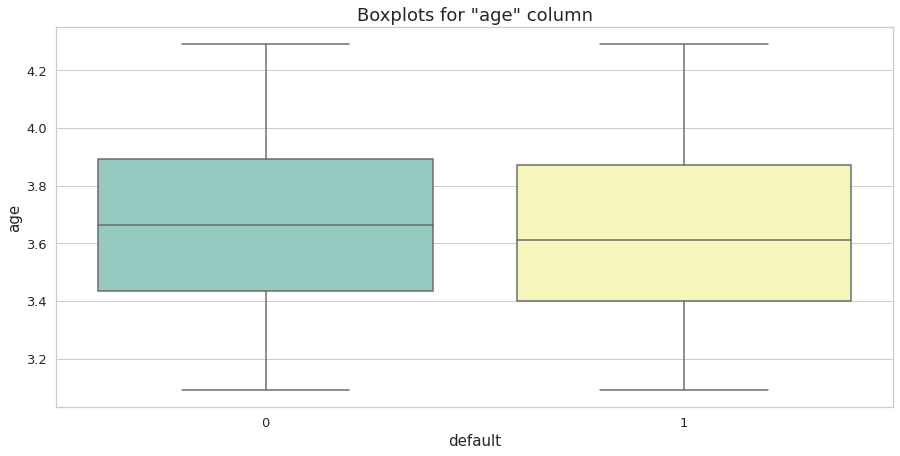

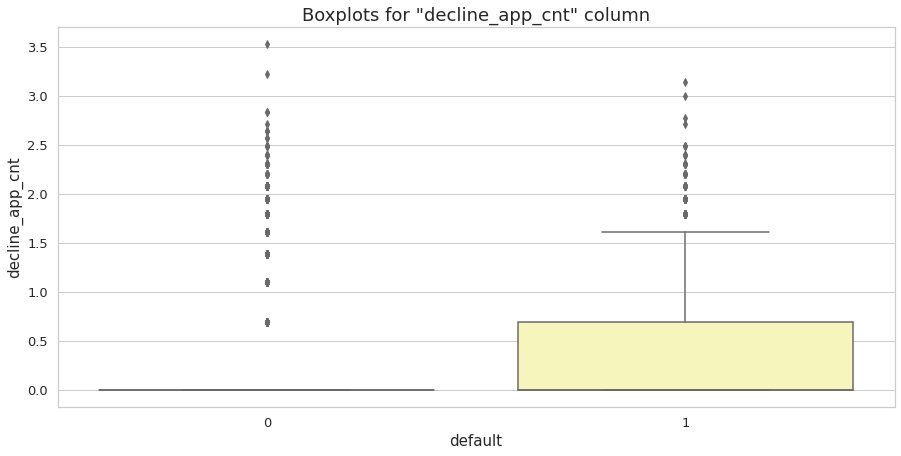

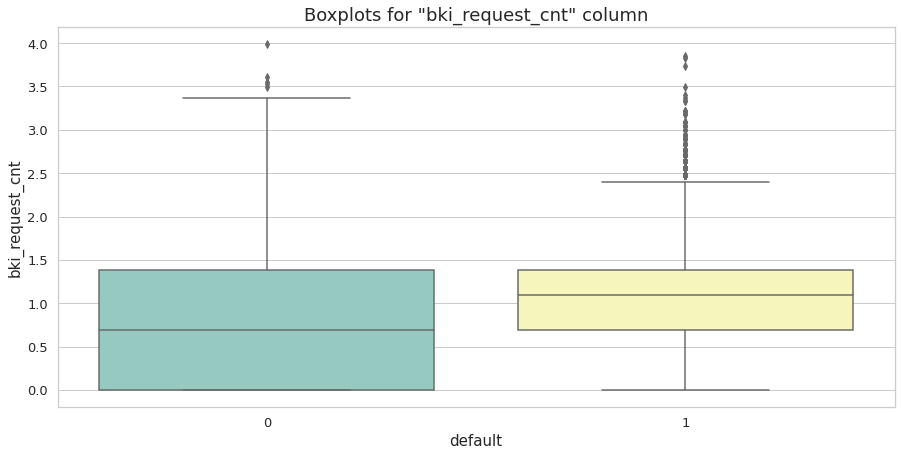

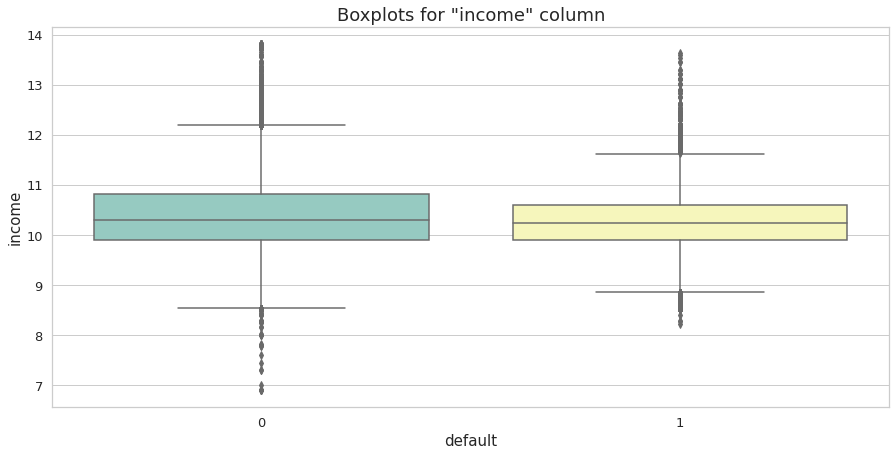

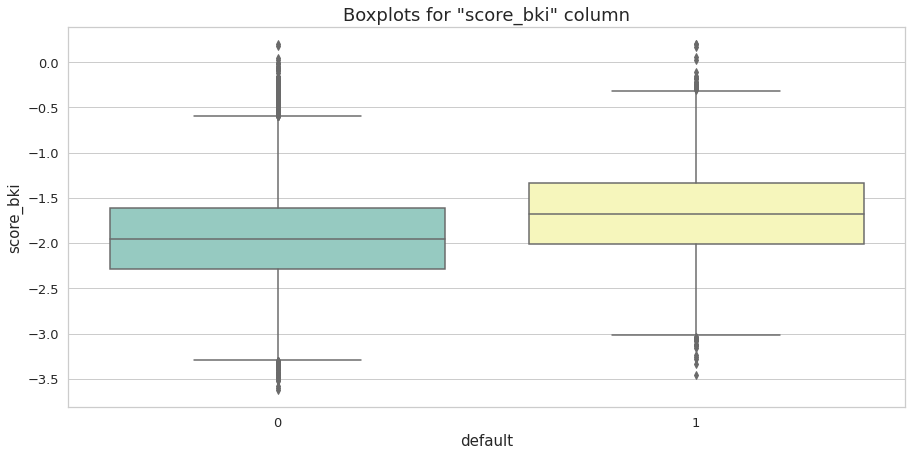

In [109]:
for col in num_cols:
    plt.figure(figsize=(15, 7))
    sns.boxplot(x='default', y=col, data=data[data['sample'] == 1], palette='Set3')
    plt.title(f'Boxplots for "{col}" column', size=18)

**In average:**

* Default clients are younger
* Default clients have more refused applications
* Default clients have more requests to Credit Bureau
* Default clients have lower income
* Lots of outliers according to IQR

Probably if we get rid of outliers, the ML model will perform better.
Removing outliers according to IQR:

In [110]:
def outliers_iqr(data, column):
    quartile_1, quartile_3 = np.percentile(data[column], [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((data[column] > upper_bound) | (data[column] < lower_bound))[0]

In [111]:
for col in num_cols:
    outliers = outliers_iqr(data, col)
    print(f'Amount of outliers for "{col}": {len(outliers)}')

Amount of outliers for "age": 0
Amount of outliers for "decline_app_cnt": 18677
Amount of outliers for "bki_request_cnt": 15
Amount of outliers for "income": 2609
Amount of outliers for "score_bki": 518


Deleting some of outliers:

In [112]:
# # Score_bki
# data.iloc[outliers_iqr(data, 'score_bki')]

Some columns have too much outliers to delete them. No changes for now.

# Feature engineering

In [113]:
data.head()

,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,2014-02-01,SCH,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,50,1,2,9.798127,4,1,0,0,1
1,2014-03-12,SCH,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,50,2,3,9.852194,4,1,0,0,1
2,2014-02-01,SCH,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,80,1,2,10.308953,1,4,1,0,1
3,2014-01-23,SCH,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,50,2,3,9.210340,1,3,0,0,1
4,2014-04-18,GRD,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,60,2,3,10.308953,1,4,1,0,1


In [130]:
# Getting months as a feature
data['month'] = data['app_date'].dt.month

# Getting time of year as a feature
data['year_time'] = data['month'].apply(lambda x: 
                                                 'winter' if x in [12, 1, 2] 
                                                 else 'spring' if x in [3, 4, 5]          
                                                 else 'summer' if x in [6, 7, 8]
                                                 else 'fall')

# Probably the fact that it is a holiday makes sense
# holidays = pd.DataFrame(['01JAN2014', '02JAN2014', '03JAN2014', '04JAN2014', '05JAN2014',
#             '06JAN2014', '08JAN2014', '07JAN2014', '23FEB2014', '08MAR2014',
#             '01MAY2014', '09MAY2014'], column='date')

# Dropping months
data.drop(['app_date'], axis=1, inplace=True)
cat_cols.extend(['month', 'year_time'])

In [131]:
# # Polynomial features
# X = data[num_cols].values
# poly = PolynomialFeatures(2)
# poly.fit_transform(X)

# Correlation Analysis

There are two main methods to select only those variables which are not correlated with each other:

1. Just select variables whose correlation coefficient is low


2. Use regularization to constrain the complexity of a model, avoid overfitting (and probably cut off insignificant features)



Correlation between numeric features:

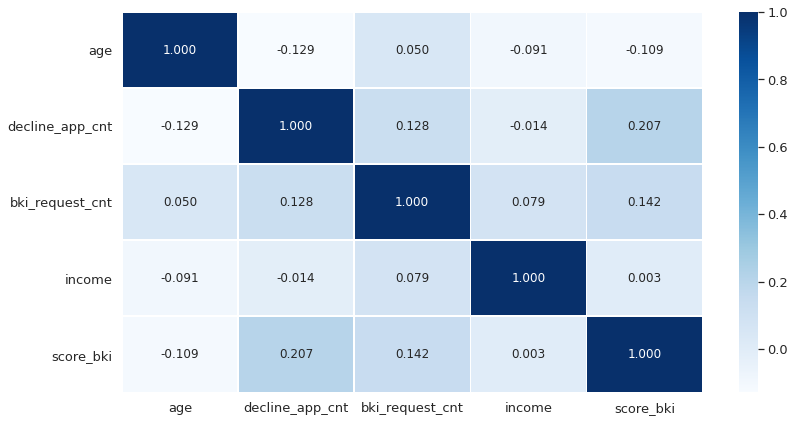

In [132]:
corr = data[num_cols].corr()
sns.heatmap(corr, annot=True, fmt='.3f', linewidth=.5, cmap='Blues');

**In general:**

* Variables have low correlation coefficients

* The highest correlation is between income and region rating which seems to be quite logical

* At least, it can be assumed that there is no multicollinearity 

Now let's check the correlation matrix for predictors and target:

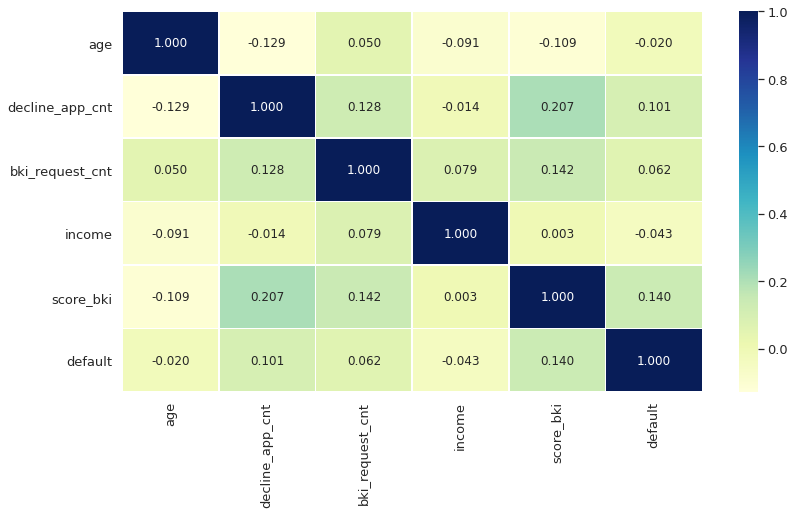

In [133]:
corr_tar = data[num_cols + [target]].corr()
sns.heatmap(corr_tar, annot=True, fmt='.3f', linewidth=.5, cmap='YlGnBu');

Well, at least there are some variables correlating with target variable.

# Significance of numeric features

Conducting ANOVA to check the significance of features.

**f1_classif** returns a tuple of two arrays: F-scores and p-values

In [134]:
f_classif(data[num_cols], data['default'])

(array([  44.27470383, 1125.30475698,  429.87098518,  204.97114223,
        2194.86554646]),
 array([2.86709448e-011, 1.82431378e-245, 2.63931697e-095, 1.89167707e-046,
        0.00000000e+000]))

P-values:
 [1.27778005e-012 8.96214000e-251 3.26668128e-101 1.45228324e-048
 0.00000000e+000]


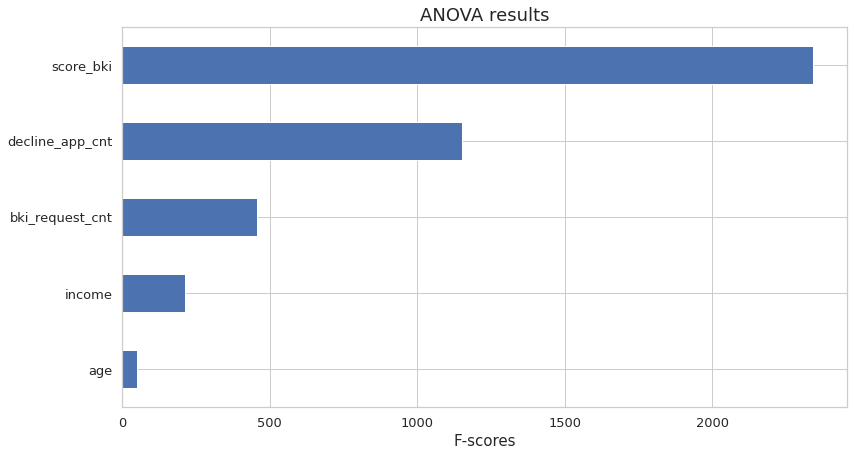

In [135]:
# The dependency between variables should be checked using only training data
imp_num = pd.Series(f_classif(data[data['sample'] == 1][num_cols], data[data['sample'] == 1][target])[0],
                    index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')
plt.title('ANOVA results', size=18)
plt.xlabel('F-scores');
print('P-values:\n', f_classif(data[data['sample'] == 1][num_cols], data[data['sample'] == 1][target])[1])

The most significant numeric features are **"score_bki"** and **"decline_app_cnt"**.

# Significance of categorical features

Making dummy variables from all the categorical features:

In [136]:
for col in cat_cols:
    data[col] = data[col].astype('O')

data = pd.get_dummies(data)

In [137]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 44 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sex               110148 non-null  int64  
 1   age               110148 non-null  float64
 2   car               110148 non-null  int64  
 3   car_type          110148 non-null  int64  
 4   decline_app_cnt   110148 non-null  float64
 5   good_work         110148 non-null  int64  
 6   score_bki         110148 non-null  float64
 7   bki_request_cnt   110148 non-null  float64
 8   income            110148 non-null  float64
 9   foreign_passport  110148 non-null  int64  
 10  default           110148 non-null  int64  
 11  sample            110148 non-null  int64  
 12  education_ACD     110148 non-null  uint8  
 13  education_GRD     110148 non-null  uint8  
 14  education_PGR     110148 non-null  uint8  
 15  education_SCH     110148 non-null  uint8  
 16  education_UGR     11

Changing **bin_cols** list:

In [138]:
bin_cols.extend(data.columns[13:])
bin_cols

['sex',
 'car',
 'car_type',
 'good_work',
 'foreign_passport',
 'education_GRD',
 'education_PGR',
 'education_SCH',
 'education_UGR',
 'region_rating_20',
 'region_rating_30',
 'region_rating_40',
 'region_rating_50',
 'region_rating_60',
 'region_rating_70',
 'region_rating_80',
 'home_address_1',
 'home_address_2',
 'home_address_3',
 'work_address_1',
 'work_address_2',
 'work_address_3',
 'sna_1',
 'sna_2',
 'sna_3',
 'sna_4',
 'first_time_1',
 'first_time_2',
 'first_time_3',
 'first_time_4',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'year_time_spring',
 'year_time_winter']

**Mutual information:**

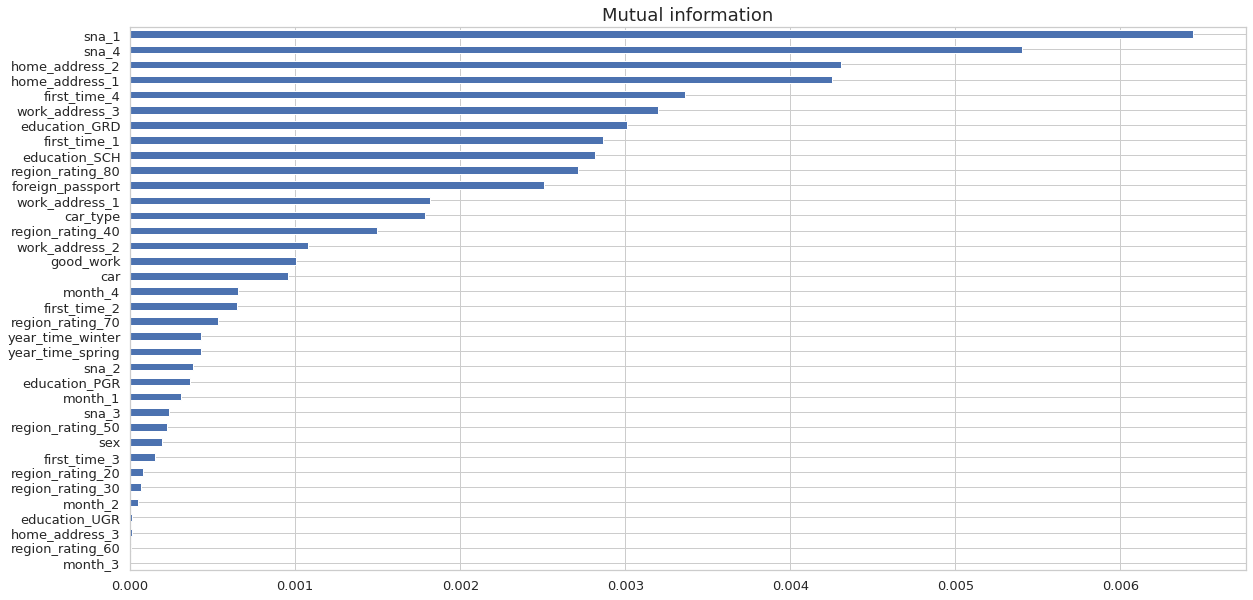

In [139]:
imp_cat = pd.Series(mutual_info_classif(data[data['sample'] == 1][bin_cols], data[data['sample'] == 1][target],
                                     discrete_features =True), index = bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', figsize=(20, 10))
plt.title('Mutual information', size=18);

* The most important feature is **home_address**

* The least important feature is **education_UGR**



Computing **Chi Squared** stats:

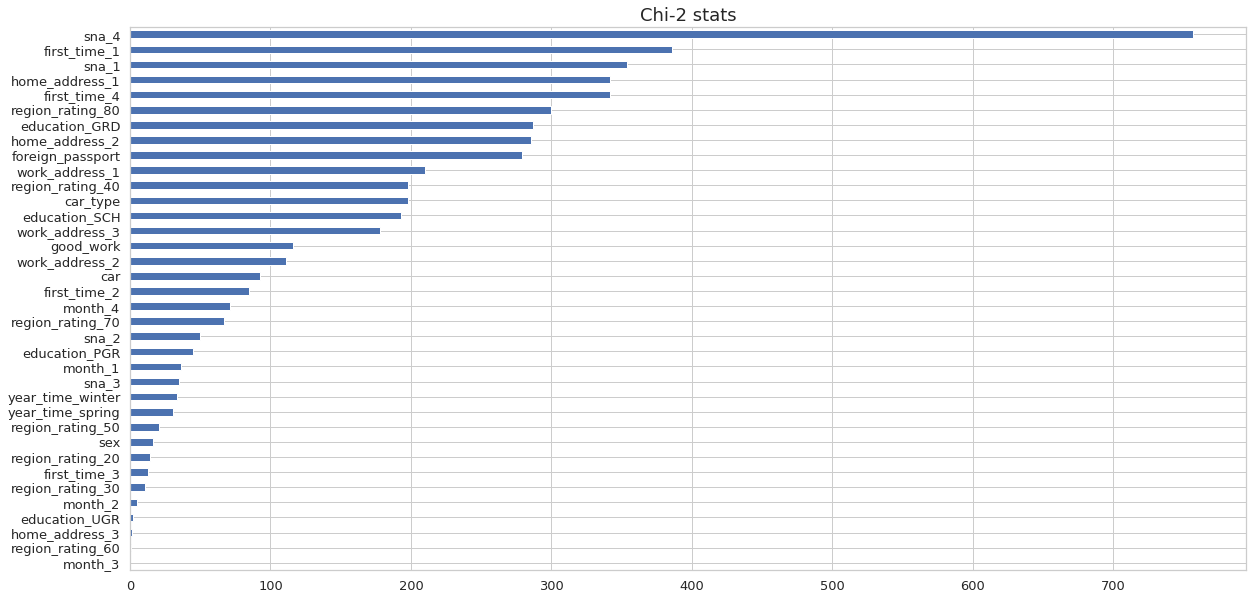

In [37]:
chi_2 = pd.Series(chi2(data[data['sample'] == 1][bin_cols], data[data['sample'] == 1][target])[0], index=bin_cols)
chi_2.sort_values().plot(kind='barh', figsize=(20, 10))
plt.title('Chi-2 stats', size=18);

In general, both tests show quite similar results of significance for categorical features

**home_address_3**, **education_UGR**, **month_3** and **region_rating_60** are not valuable:

In [140]:
data.drop(['home_address_3', 'education_UGR', 'month_3', 'region_rating_60'], axis=1, inplace=True)

# Machine Learning Model

In [141]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 40 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sex               110148 non-null  int64  
 1   age               110148 non-null  float64
 2   car               110148 non-null  int64  
 3   car_type          110148 non-null  int64  
 4   decline_app_cnt   110148 non-null  float64
 5   good_work         110148 non-null  int64  
 6   score_bki         110148 non-null  float64
 7   bki_request_cnt   110148 non-null  float64
 8   income            110148 non-null  float64
 9   foreign_passport  110148 non-null  int64  
 10  default           110148 non-null  int64  
 11  sample            110148 non-null  int64  
 12  education_ACD     110148 non-null  uint8  
 13  education_GRD     110148 non-null  uint8  
 14  education_PGR     110148 non-null  uint8  
 15  education_SCH     110148 non-null  uint8  
 16  region_rating_20  11

In [142]:
X = data[data['sample'] == 1].drop(['default', 'sample'], axis=1).values
y = data[data['sample'] == 1][target].values

Splitting the data and training the **logistic regression** model:

In [143]:
# Splitting
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Standardizing features
scaler = RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [155]:
# Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)

In [156]:
roc_auc_score(y_val, y_proba[:, 1])

0.744603010818546

**ROC, AUC:**

In [146]:
probs = y_proba[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, probs)
roc_auc = roc_auc_score(y_val, probs)

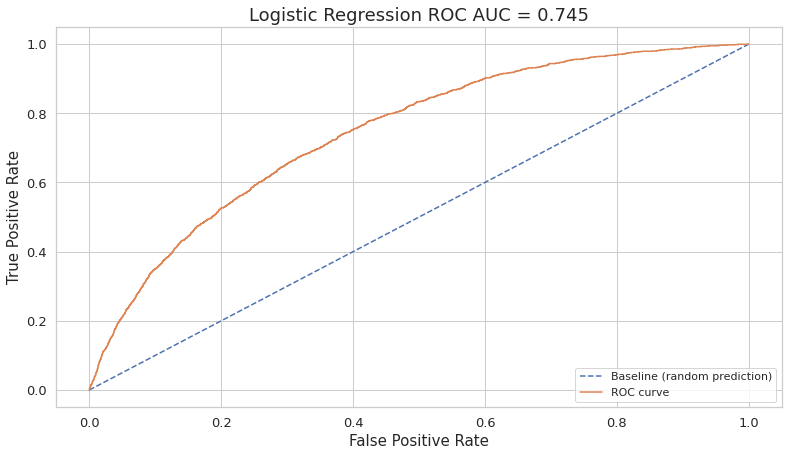

In [147]:
# Building ROC-curve
plt.figure()
plt.plot([0, 1], label='Baseline (random prediction)', linestyle='--')
plt.plot(fpr, tpr, label='ROC curve')
plt.title('Logistic Regression ROC AUC = {}'.format(round(roc_auc, 3)), size=18)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show();

**Cross-validation** of the model:

In [167]:
# cv = cross_validate(model, X, y, cv=7, scoring=('f1', 'roc_auc'))
# cv['test_roc_auc'].mean()
# => 0.7348785727584566

# Hyperparameter  tuning

It is necessary to figure out what value is optimal for regularization parameter for logistic regression.

In **sklearn** there are two ways of doing that: using **GridSearchCV** or **RandomizedSearchCV**.

Firstly, let's use **GridSearchCV**:

In [178]:
# # Defining X and y
# X = data[data['sample'] == 1].drop(['default', 'sample'], axis=1).values
# y = data[data['sample'] == 1][target].values

# # Splitting
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# # Standardizing features
# scaler = RobustScaler()
# X = scaler.fit_transform(X)

# # Hyperparameters
# hyperparameters = [
#                     {
#                      'C': np.linspace(0, 2, 10),
#                      'penalty': ['l2'],
#                      'class_weight': ['balanced', None]
#                     },
# #                     {
# #                      'penalty': ['none'],
# #                      'class_weight': ['balanced', None]
# #                     }
                        
# #                     {
# #                      'l1_ratio': np.linspace(0, 1, 10),
# #                      'penalty': ['elasticnet'],
# #                      'solver': ['saga']   
# #                     }
#                   ]

# # Creating a model
# model = LogisticRegression(max_iter=1000)
# model.fit(X, y)

# # Using grid search with 5 folds
# clf = GridSearchCV(model, hyperparameters, scoring='roc_auc',
#                    cv=5, verbose=0)

# model = clf.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:759: RuntimeWarning:

divide by zero encountered in double_scalars

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:122: RuntimeWarning:

invalid value encountered in double_scalars

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:127: RuntimeWarning:

invalid value encountered in multiply

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1417, in fit
    for class_, warm_start_coef_ in zip(classes_, warm_start_coef))
 

Looking at the results of grid search:

In [179]:
print(model.best_params_)
print(model.best_estimator_)
print(model.best_score_)

# {'C': 0.3333333333333333, 'class_weight': 'balanced', 'penalty': 'l2'}
# LogisticRegression(C=0.3333333333333333, class_weight='balanced', max_iter=1000)
# 0.7323304368645942

{'C': 0.2222222222222222, 'class_weight': 'balanced', 'penalty': 'l2'}
LogisticRegression(C=0.2222222222222222, class_weight='balanced', max_iter=1000)
0.7323492515801447


In [166]:
# y_pred = clf.predict(X_val)
# probs = clf.predict_proba(X_val)[:, 1]
# print(roc_auc_score(y_val, probs))
# print(f1_score(y_val, y_pred))

# => 0.7442304960122251
# => 0.3386416224309242

0.7442304960122251
0.3386416224309242


The model has adequate f1_score and roc_auc_score which means that it does not predict only one of the classes but both of them.

In my case, using any **regularization** parameters except *C=1* and *penaly='l2'* lead to worse model results, that is why my final decision was to set these parameters.

# Preprocessing in form of Class

In [182]:
class CreditScoring():
    def __init__(self):
        self.train = pd.read_csv('../input/sf-dst-scoring/train.csv')
        self.test = pd.read_csv('../input/sf-dst-scoring/test.csv')
        self.train['sample'] = 1
        self.test['sample'] = 0
        self.test['default'] = 0  # Filling with 0, since no values here
        self.data = pd.concat([self.train, self.test], axis=0, ignore_index=True)
        self.sample_sub = pd.DataFrame()
    
    def preproc_data(self):
        # Dropping an unnecessary column
        self.data.drop(['client_id'], axis=1, inplace=True)
        
        # Converting the column with categorical dates into datetime format
        self.data['app_date'] = pd.to_datetime(self.data['app_date'])
        
        # Lists with column names
        num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki', 'region_rating']
        bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
        cat_cols = ['education', 'home_address', 'work_address', 'first_time', 'sna']
        target = 'default'
        
        if self.data.isna().sum().sum() != 0:
            # Imputing missing values in education
            X = self.data[~self.data.education.isna()].drop(['app_date', 'default', 'sample'], axis=1)
            X_nan = self.data[self.data.education.isna()].drop(['app_date', 'default', 'sample'], axis=1)

            encoder = LabelEncoder()
            encoder.fit(X.education)
            education_labeled = encoder.transform(X.education)
            X.loc[:, ['education']] = education_labeled

            X = pd.get_dummies(X)
            X_nan = pd.get_dummies(X_nan.fillna(value=0))

            scaler = RobustScaler()
            scaler.fit(X.iloc[:, 1:])
            X_train = scaler.transform(X.iloc[:, 1:])
            y_train = X.iloc[:, 0].values

            X_test = scaler.transform(X_nan.iloc[:, 1:])
            y_test = X_nan.iloc[:, 0].values

            knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            y_pred = encoder.inverse_transform(y_pred)

            nan_indices = self.data[self.data.education.isna()].index
            self.data.iloc[nan_indices, 1] = y_pred
        
        # Making some columns look more "normal"
        self.data['income'] = [np.log(x) for x in self.data['income']]
        self.data['age'] = [np.log(x + 1) for x in self.data['age']]
        self.data['decline_app_cnt'] = [np.log(x + 1) for x in self.data['decline_app_cnt']]
        self.data['bki_request_cnt'] = [np.log(x + 1) for x in self.data['bki_request_cnt']]
                
        # Getting rid of outliers
#         self.data = self.data[outliers_iqr(self.data, 'bki_request_cnt')]
         
        # Encoding binary features
        label_encoder = LabelEncoder()
        for column in bin_cols:
            self.data[column] = label_encoder.fit_transform(self.data[column])
        
        # Getting months as a feature
        self.data['month'] = self.data['app_date'].dt.month

        # Getting time of year as a feature
        self.data['year_time'] = self.data['month'].apply(lambda x: 
                                                                     'winter' if x in [12, 1, 2] 
                                                                     else 'spring' if x in [3, 4, 5]          
                                                                     else 'summer' if x in [6, 7, 8]
                                                                     else 'fall')
        
        # Using rating as a categorical feature
        self.data['region_rating'] = self.data['region_rating'].astype('O')
        num_cols.remove('region_rating')
        cat_cols.append('region_rating')
        
        # Dropping timestamp
        self.data.drop(['app_date'], axis=1, inplace=True)
        cat_cols.extend(['month', 'year_time'])

        # Converting cats to object dtype
        for col in cat_cols:
            self.data[col] = self.data[col].astype('O')

        self.data = pd.get_dummies(self.data)
        
        # Changing bin_cols list
        bin_cols.extend(self.data.columns[12:])
        
        # Dropping insignificant columns
        self.data.drop(['home_address_3', 'education_UGR', 'month_3', 'region_rating_60'], axis=1, inplace=True)

        # Getting features and target
        self.X = self.data[self.data['sample'] == 1].drop(['default', 'sample'], axis=1).values
        self.y = self.data[self.data['sample'] == 1][target].values
        
        # Getting test sample      
        self.X_test = self.data[self.data['sample'] == 0].drop(['default', 'sample'], axis=1).values
        self.y_test = self.data[self.data['sample'] == 0][target].values
        
    def train_model_sub(self):
        # Training a model on the whole training dataset
        X_train = self.data[self.data['sample'] == 1].drop(['default', 'sample'], axis=1).values
        y_train = self.data[self.data['sample'] == 1]['default'].values
        X_test = self.data[self.data['sample'] == 0].drop(['default', 'sample'], axis=1).values
        y_test = self.data[self.data['sample'] == 0]['default'].values
        
        # Polynomial features
#         poly = PolynomialFeatures(2)
#         X_test = poly.fit_transform(X_train)
#         X_test = poly.fit_transform(X_test)
        
        # Standardizing features
        scaler = RobustScaler()  # Robust to outliers
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Model
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)

        self.sample_sub['client_id'] = self.test['client_id']
        self.sample_sub['default'] = y_proba[:, 1]

Preprocessing the data and training a model:

In [ ]:
cs = CreditScoring()
cs.preproc_data()
cs.train_model_sub()

In [ ]:
sample_submission = cs.sample_sub
sample_submission.to_csv('submission.csv', index=False)

In [ ]:
sample_submission